# Should I buy/sell Microsoft today?

In this project, I tested a few strategies for deciding whether to buy/sell a share of Microsoft (MSFT) based on technical data, including candlestick components (open-close-low-high), volume, and rolling averages.

Dataset from [quandl.com](https://www.quandl.com/data/EOD/MSFT-Microsoft-Corporation-MSFT-Stock-Prices-Dividends-and-Splits)

In [1]:
# analysis
import pandas as pd
import numpy as np
import datetime
from scipy import stats

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

In [3]:
#1.1 Read CSV data in Pandas dataframe

df = pd.read_csv("./EOD-MSFT.csv",usecols=['Date','Open','High','Low','Close','Volume'])  
df.columns = ['date', 'open','high','low','close','volume']
df = df.sort_index(ascending=False)
df.head()

,date,open,high,low,close,volume
1089,2013-09-03,31.7500,32.07,31.29,31.880,154507000.0
1088,2013-09-04,31.3900,31.47,31.11,31.195,142320600.0
1087,2013-09-05,31.1000,31.44,30.95,31.235,71644900.0
1086,2013-09-06,31.3100,31.39,31.13,31.152,75434900.0
1085,2013-09-09,31.2208,31.79,31.20,31.655,49628500.0


In [4]:
#1.2 Format date

df['datetime_str'] = df['date']+' '+'16:00:00'
df['datetime'] = df.apply(lambda x: datetime.datetime.strptime(x['datetime_str'], '%Y-%m-%d %H:%M:%S'), axis=1)
df['date_formatted'] = pd.to_datetime(df['datetime'],unit = 's')
df["day"] = df.date_formatted.dt.day
df["dayofweek"] = df.date_formatted.dt.dayofweek
df["dayofweek"] = df["dayofweek"]+1                 # to make data non-zero for scaling

# remove unnecessary columns
df = df.drop("datetime_str", axis=1)
df = df.drop("datetime", axis=1)
df.drop("date_formatted", inplace=True,axis=1)

In [5]:
#2 Create columns for features
#2.1 Lengths of upper and lower wicks of daily candlesticks

df["wick_top"] = df['high'] - df['open']
df["wick_bottom"] = df['close'] - df['low']

# df["wick_ratio"] = df["wick_top"] / df["wick_bottom"]  # ...creates divide-by-zero issues

In [6]:
#2.2.1 Overnight change (tomorrow, to predict)

df['open_tom'] = df.open.shift(periods=-1)
df["change_overnight"] = df['open_tom'] - df['close']
df["change_overnight"].fillna(0,inplace=True)
df = df.drop('open_tom', axis=1)

#2.2.2 Overnight change (yesterday, predictor)

df['change_overnight_last'] = df.change_overnight.shift(periods=-1)
df['change_overnight_last'].fillna(0,inplace=True)

In [7]:
#2.2.3 Intraday change (today, to predict)

df['change_intraday'] = df['close'] - df['open']

#2.2.4 Intraday change (yesterday, predictor)

df['change_intraday_last'] = df.change_intraday.shift(periods=-1)
df['change_intraday_last'].fillna(0,inplace=True)

In [8]:
print(df.columns.tolist())

['date', 'open', 'high', 'low', 'close', 'volume', 'day', 'dayofweek', 'wick_top', 'wick_bottom', 'change_overnight', 'change_overnight_last', 'change_intraday', 'change_intraday_last']


In [9]:
#2.4 Upper and lower Bollinger Bands
## Note: 20 is conventional

s1 = df["close"]

df["rolling_mean_20d"] = s1.rolling(20).mean()
df["rolling_std_20d"] = s1.rolling(20).std()
df["rolling_mean_20d"].fillna(0,inplace=True)
df["rolling_std_20d"].fillna(0,inplace=True)

In [10]:
def get_bollinger_bands_20(x):
    upper_band, lower_band = x["rolling_mean_20d"] + 2*x["rolling_std_20d"], x["rolling_mean_20d"] - 2*x["rolling_std_20d"]
    return upper_band, lower_band

df["bollinger_band_20"] = df[["rolling_mean_20d","rolling_std_20d"]].apply(get_bollinger_bands_20,axis=1)
df["upper_bollinger_band_20"] = df["bollinger_band_20"].apply(lambda x: x[0])
df["lower_bollinger_band_20"] = df["bollinger_band_20"].apply(lambda x: x[1])
df = df.drop("bollinger_band_20", axis = 1)

df.drop("rolling_mean_20d", inplace=True,axis=1)
df.drop("rolling_std_20d", inplace=True,axis=1)

In [11]:
#2.5 Rolling intraday and overnight change

s2 = df["change_intraday"]

df["rolling_intraday_mean_20d"] = s2.rolling(20).mean()
df["rolling_intraday_std_20d"] = s2.rolling(20).std()
df["rolling_intraday_mean_20d"].fillna(0,inplace=True)
df["rolling_intraday_std_20d"].fillna(0,inplace=True)

s3 = df["change_overnight"]

df["rolling_overnight_mean_20d"] = s3.rolling(20).mean()
df["rolling_overnight_std_20d"] = s3.rolling(20).std()
df["rolling_overnight_mean_20d"].fillna(0,inplace=True)
df["rolling_overnight_std_20d"].fillna(0,inplace=True)

In [12]:
#2.5.2 Overbought, oversold

df["overbought_deg"] = df["upper_bollinger_band_20"] - df["close"]
df["oversold_deg"] = df["lower_bollinger_band_20"] - df["close"]

df["is_overbought"] = np.where(df["overbought_deg"]>0, 1, 0)
df["is_oversold"] = np.where(df["oversold_deg"]>0, 1, 0)

In [13]:
#2.6 Day of week (M-F) and dummy variables thereof

dayofweek_dummies = pd.get_dummies(df.dayofweek).astype(int)
dowk = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dayofweek_dummies.columns = ["dayis_"+dowk[i] for i in range(0,5)]

df = pd.concat([df, dayofweek_dummies],axis=1)

In [14]:
#2.8 Reorganize columns

df = df[df.columns.tolist()[0:1]+      # date
        df.columns.tolist()[6:8]+      # day, dayofweek
        df.columns.tolist()[5:6]+      # volume
        df.columns.tolist()[1:5]+      # open : close
        df.columns.tolist()[8:]   ]    # wick_top : 

df.head(30)  # lots of "0.000" data, need to get rid of them
# df.tail(30)

,date,day,dayofweek,volume,open,high,low,close,wick_top,wick_bottom,...,rolling_overnight_std_20d,overbought_deg,oversold_deg,is_overbought,is_oversold,dayis_Mon,dayis_Tue,dayis_Wed,dayis_Thu,dayis_Fri
1089,2013-09-03,3,2,154507000.0,31.7500,32.0700,31.290,31.880,0.3200,0.590,...,0.000000,-31.880000,-31.880000,0,0,0,1,0,0,0
1088,2013-09-04,4,3,142320600.0,31.3900,31.4700,31.110,31.195,0.0800,0.085,...,0.000000,-31.195000,-31.195000,0,0,0,0,1,0,0
1087,2013-09-05,5,4,71644900.0,31.1000,31.4400,30.950,31.235,0.3400,0.285,...,0.000000,-31.235000,-31.235000,0,0,0,0,0,1,0
1086,2013-09-06,6,5,75434900.0,31.3100,31.3900,31.130,31.152,0.0800,0.022,...,0.000000,-31.152000,-31.152000,0,0,0,0,0,0,1
1085,2013-09-09,9,1,49628500.0,31.2208,31.7900,31.200,31.655,0.5692,0.455,...,0.000000,-31.655000,-31.655000,0,0,1,0,0,0,0
1084,2013-09-10,10,2,56881200.0,31.9000,32.4000,31.790,32.390,0.5000,0.600,...,0.000000,-32.390000,-32.390000,0,0,0,1,0,0,0
1083,2013-09-11,11,3,39087500.0,32.5700,32.9300,32.530,32.740,0.3600,0.210,...,0.000000,-32.740000,-32.740000,0,0,0,0,1,0,0
1082,2013-09-12,12,4,32860200.0,32.7200,32.7800,32.590,32.690,0.0600,0.100,...,0.000000,-32.690000,-32.690000,0,0,0,0,0,1,0
1081,2013-09-13,13,5,40899000.0,32.7700,33.0700,32.505,33.030,0.3000,0.525,...,0.000000,-33.030000,-33.030000,0,0,0,0,0,0,1
1080,2013-09-16,16,1,52839700.0,33.3800,33.5000,32.730,32.801,0.1200,0.071,...,0.000000,-32.801000,-32.801000,0,0,1,0,0,0,0


In [15]:
#2.9 Housekeeping

# Create copy of data as time series (i.e. indexed by date) for easy graphing
dft = df.copy()
dft.set_index('date', inplace=True)

# dft.index = dft.index.map(lambda x: pd.to_datetime(dft.date[x],format="%Y-%m-%d"))

# Cut first/last entries in dataframe due to NaN or '0.000' values in rolling features

df = df[20:-20]
dft = dft[20:-20]

# Reset index numbering (to prevent mismatched joins)

df = df.reset_index(drop=True)
df.drop("date", inplace=True,axis=1)

# Create deep copies 
master_df  = df.copy()
master_dft = dft.copy()

In [56]:
df = master_df        # to reset dataset
df.to_csv('MSFT data unscaled.csv')

dft.head()                    # should be (1050 rows by 28 columns)

,day,dayofweek,volume,open,high,low,close,wick_top,wick_bottom,change_overnight,...,rolling_overnight_std_20d,overbought_deg,oversold_deg,is_overbought,is_oversold,dayis_Mon,dayis_Tue,dayis_Wed,dayis_Thu,dayis_Fri
date,,,,,,,,,,,,,,,,,,,,,
2013-10-01,1,2,36718700.0,33.35,33.61,33.30,33.58,0.26,0.28,-0.22,...,0.213750,0.537600,-2.480700,1,0,0,1,0,0,0
2013-10-02,2,3,46946800.0,33.36,34.03,33.29,33.92,0.67,0.63,-0.04,...,0.211976,0.287885,-2.638485,1,0,0,0,1,0,0
2013-10-03,3,4,38703800.0,33.88,34.00,33.42,33.86,0.12,0.44,-0.17,...,0.218312,0.376251,-2.344351,1,0,0,0,0,1,0
2013-10-04,4,5,33008100.0,33.69,33.99,33.62,33.88,0.30,0.26,-0.28,...,0.230499,0.297954,-2.033254,1,0,0,0,0,0,1
2013-10-07,7,1,35069300.0,33.60,33.71,33.20,33.30,0.11,0.10,0.01,...,0.225140,0.774240,-1.185040,1,0,1,0,0,0,0


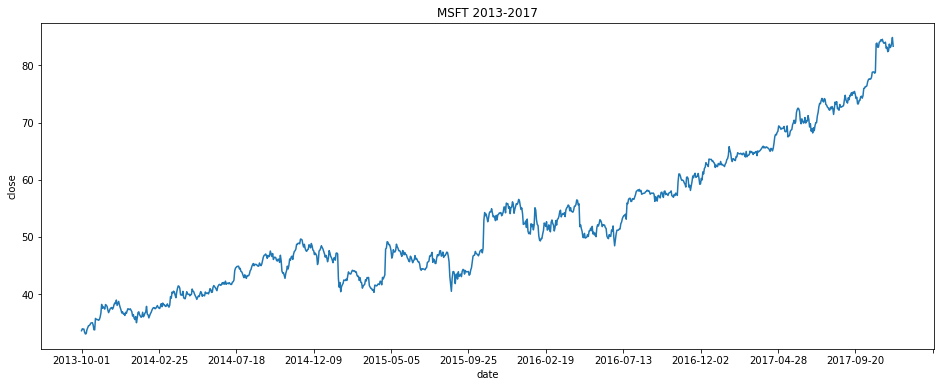

In [17]:
# here's the price of Microsoft stock over time

plt.figure(figsize = (16,6))

ax = sns.lineplot(x=dft.index, y="close", data=dft)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.set_title('MSFT 2013-2017')

plt.show()

## Exploratory Data Analysis

In [18]:
#3.1 Define features

features_basic =  ['volume', 'change_intraday',                 # why no 'change_overnight'? it's the outcome
                   'change_overnight_last', 'change_intraday_last',
                   'wick_top', 'wick_bottom', 'overbought_deg', 'oversold_deg',
                   'day', 'dayofweek']                          # don't need to scale, no correlation (see below)

features_rolling = ['upper_bollinger_band_20', 'lower_bollinger_band_20',
                         'rolling_intraday_mean_20d', 'rolling_intraday_std_20d',
                         'rolling_overnight_mean_20d', 'rolling_overnight_std_20d',
                         'overbought_deg', 'oversold_deg']

features_for_scaling =  ['volume', 'change_intraday', 'change_overnight',               
                        'change_overnight_last', 'change_intraday_last',
                         'wick_top', 'wick_bottom', 'overbought_deg', 'oversold_deg',                              
                         'upper_bollinger_band_20', 'lower_bollinger_band_20',
                         'rolling_intraday_mean_20d', 'rolling_intraday_std_20d',
                         'rolling_overnight_mean_20d', 'rolling_overnight_std_20d']

In [19]:
#3.2 Scale features         # is skew (generally) identical for scaled data??

from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()

X = df[features_for_scaling]
arr_scaled_std = scaler_std.fit_transform(X)

scaled_features = []

for name in features_for_scaling:
    name = name + "_scaled"
    scaled_features.append(name)

df_scaled = pd.DataFrame(arr_scaled_std, columns=scaled_features)

In [20]:
# Replace std with minmax: volume, change_overnight_last, [change_intraday,] change_intraday_last, wick_top, wick_bottom

from sklearn.preprocessing import MinMaxScaler

scaler_mmx = MinMaxScaler()

features_for_scaling_mmx = ['volume', 'change_overnight_last',
                            'change_intraday', 'change_intraday_last',
                            'overbought_deg', 'oversold_deg',
                            'wick_top', 'wick_bottom']                           

X = df[features_for_scaling_mmx]
arr_scaled_mmx = scaler_mmx.fit_transform(X)

volume_mmx = pd.Series(arr_scaled_mmx[:,0])
change_overnight_last_mmx = pd.Series(arr_scaled_mmx[:,1])
change_intraday_mmx = pd.Series(arr_scaled_mmx[:,2])
change_intraday_last_mmx = pd.Series(arr_scaled_mmx[:,3])
change_wick_top_mmx = pd.Series(arr_scaled_mmx[:,4])
change_wick_bottom_mmx = pd.Series(arr_scaled_mmx[:,5])
overbought_deg_mmx = pd.Series(arr_scaled_mmx[:,6])
oversold_deg_mmx = pd.Series(arr_scaled_mmx[:,7])
        
df_scaled['volume_scaled'] = volume_mmx
df_scaled['change_overnight_last_scaled'] = change_overnight_last_mmx
df_scaled['change_intraday_scaled'] = change_intraday_mmx
df_scaled['change_intraday_last_scaled'] = change_intraday_last_mmx
df_scaled['wick_top_scaled'] = change_wick_top_mmx
df_scaled['wick_bottom_scaled'] = change_wick_bottom_mmx
df_scaled['overbought_deg_scaled'] = overbought_deg_mmx
df_scaled['oversold_deg_scaled'] = oversold_deg_mmx

df_scaled

,volume_scaled,change_intraday_scaled,change_overnight_scaled,change_overnight_last_scaled,change_intraday_last_scaled,wick_top_scaled,wick_bottom_scaled,overbought_deg_scaled,oversold_deg_scaled,upper_bollinger_band_20_scaled,lower_bollinger_band_20_scaled,rolling_intraday_mean_20d_scaled,rolling_intraday_std_20d_scaled,rolling_overnight_mean_20d_scaled,rolling_overnight_std_20d_scaled
0,0.150146,0.554054,-0.494774,0.415719,0.628378,0.261761,0.688343,0.090909,0.126126,-1.669991,-1.619677,0.028295,-1.064983,0.479451,-0.725397
1,0.202572,0.628378,-0.113803,0.402275,0.497748,0.241268,0.676859,0.234266,0.283784,-1.662417,-1.603927,0.408147,-0.966440,0.507475,-0.732336
2,0.160321,0.497748,-0.388949,0.390900,0.545045,0.248520,0.698267,0.041958,0.198198,-1.660037,-1.583689,0.330164,-0.964364,0.382640,-0.707557
3,0.131127,0.545045,-0.621764,0.420889,0.434685,0.242094,0.720910,0.104895,0.117117,-1.664928,-1.555070,0.505248,-0.985363,0.204914,-0.659898
4,0.141692,0.434685,-0.007978,0.426060,0.434685,0.281182,0.782646,0.038462,0.045045,-1.673629,-1.531886,0.135861,-0.986222,0.085174,-0.680857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.067287,0.340090,-0.240794,0.425026,0.558559,0.447813,0.708360,0.024476,0.031532,2.675618,2.685359,-1.037353,0.358639,2.496233,3.489422
1046,0.000000,0.558559,0.076682,0.440538,0.628378,0.349432,0.806530,0.146853,0.216216,2.587629,2.814911,-0.690204,0.339197,-0.336770,-0.439360
1047,0.055560,0.628378,0.394157,0.402275,0.684685,0.299789,0.762198,0.234266,0.256757,2.588056,2.814990,-0.126715,0.343949,-0.178815,-0.427029
1048,0.074324,0.684685,-0.388949,0.437435,0.193694,0.230534,0.683802,0.346154,0.387387,2.601992,2.809189,0.185217,0.526713,-0.504916,-0.506569


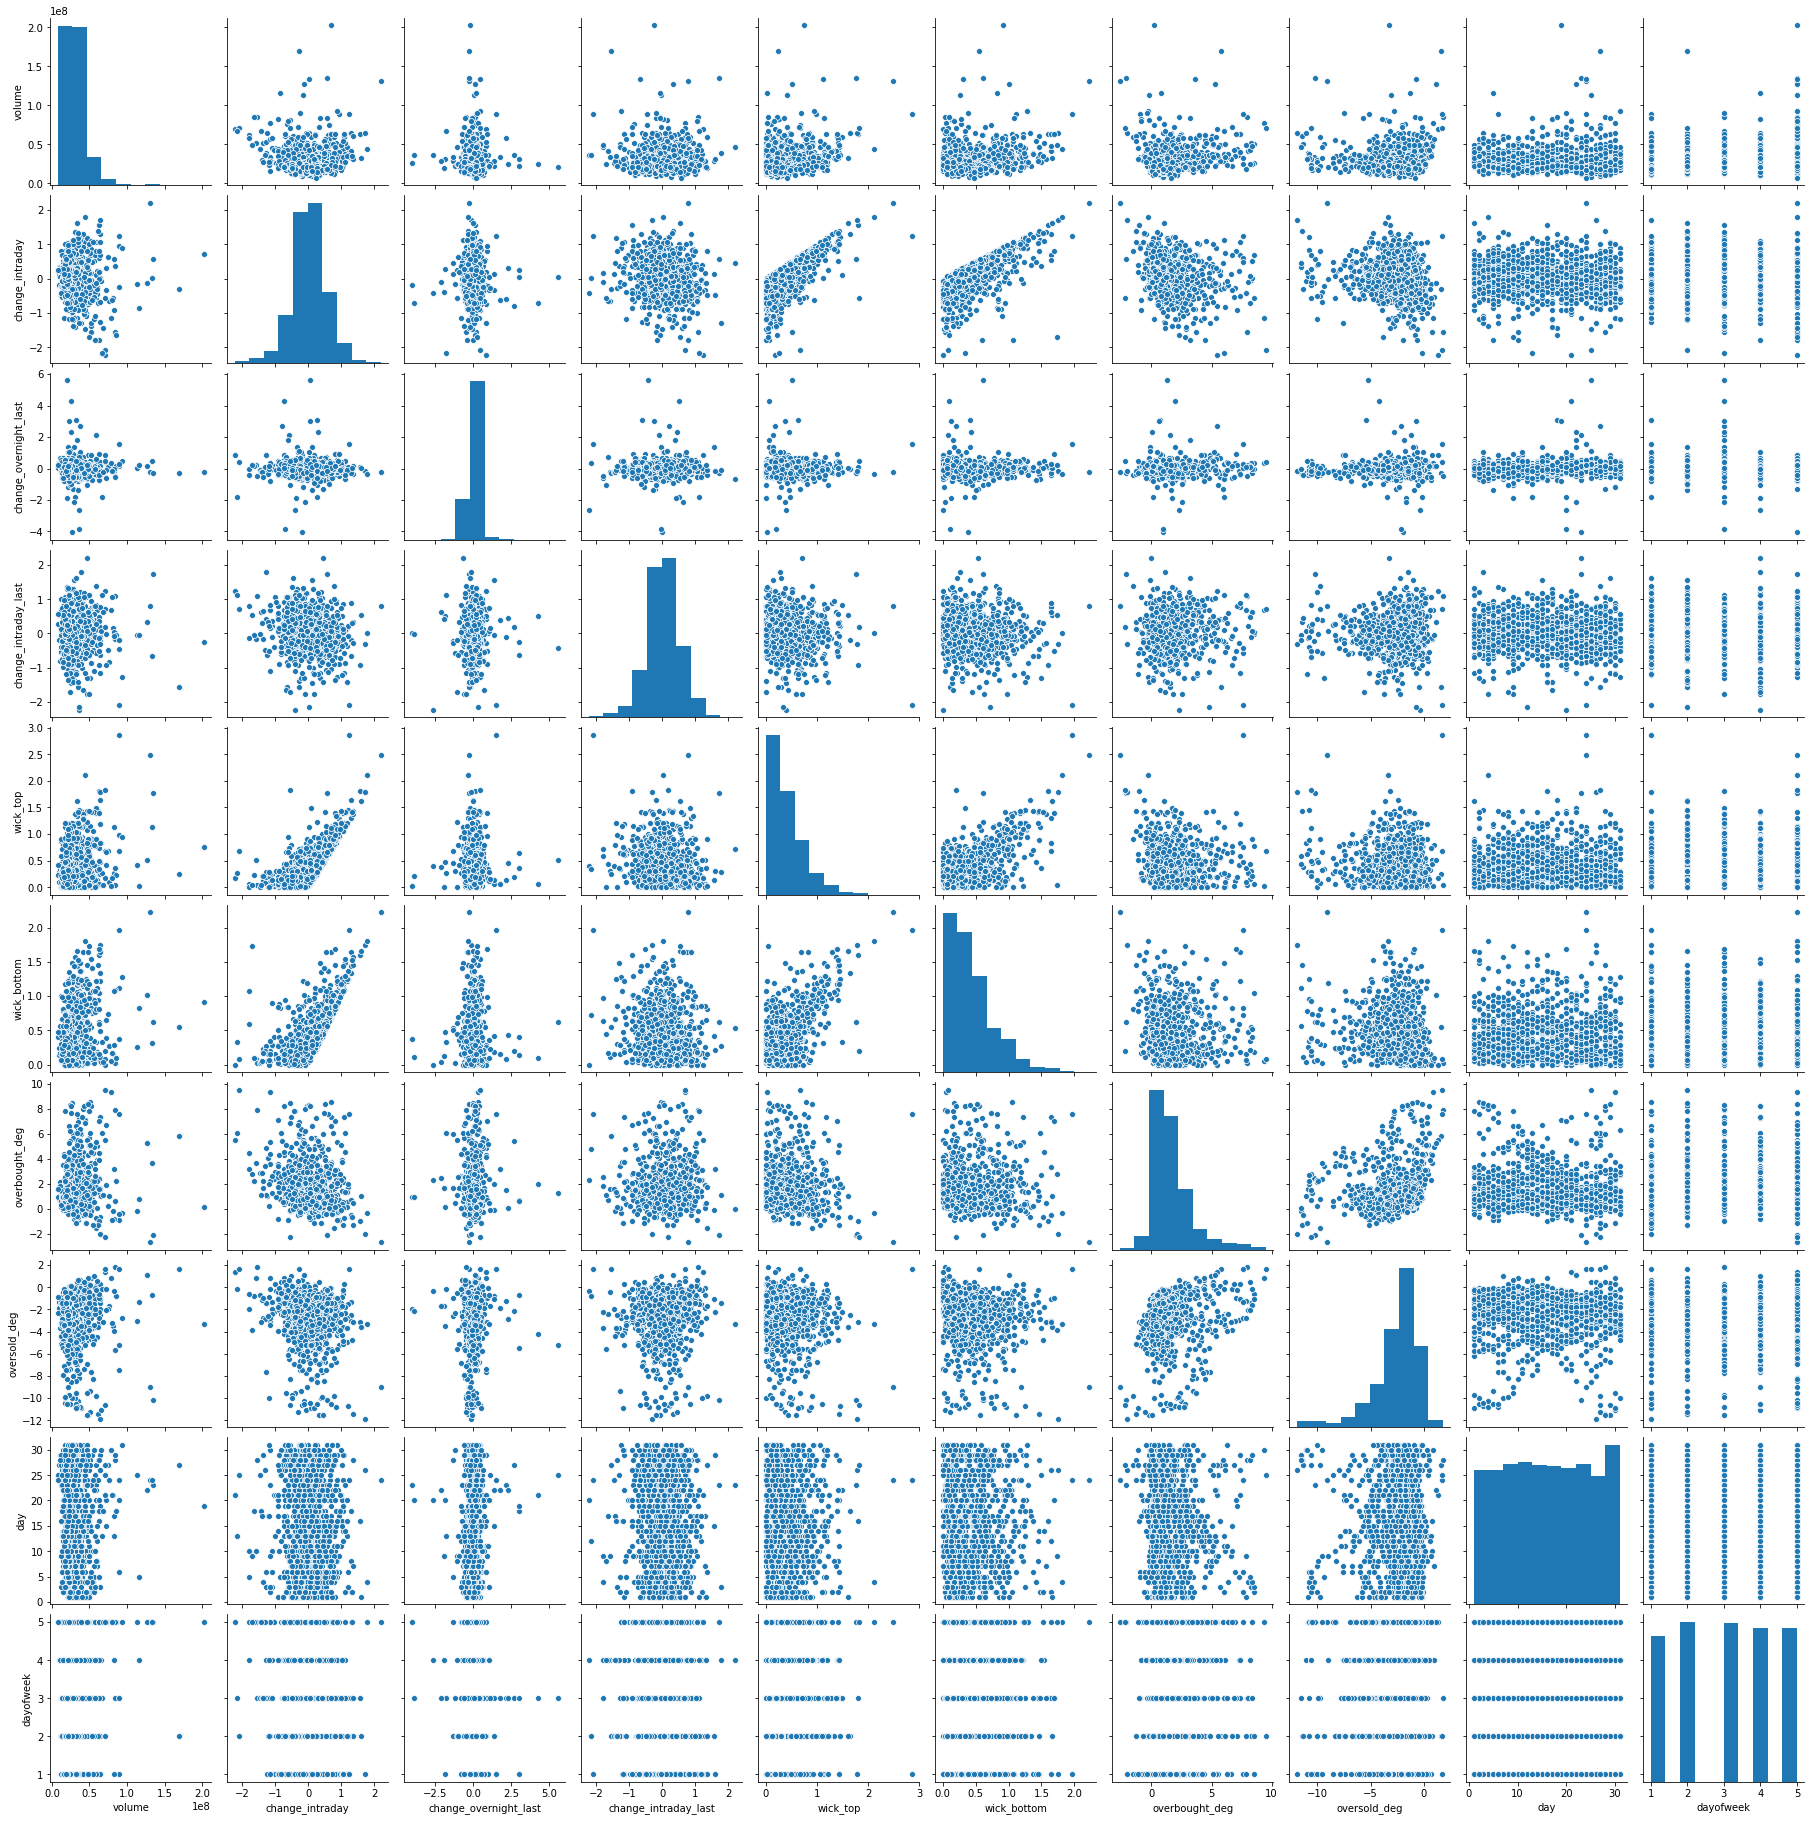

In [21]:
# 3.3 Correct for skew

arr = np.array([stats.skew(df[features_basic])])
skew_basic = pd.DataFrame(arr, columns=features_basic)

sns.pairplot(df[features_basic]);

In [23]:
skew_basic

,volume,change_intraday,change_overnight_last,change_intraday_last,wick_top,wick_bottom,overbought_deg,oversold_deg,day,dayofweek
0,3.598804,-0.240794,1.660014,-0.241081,1.596017,1.31569,1.682664,-1.631519,0.02107,-0.002458


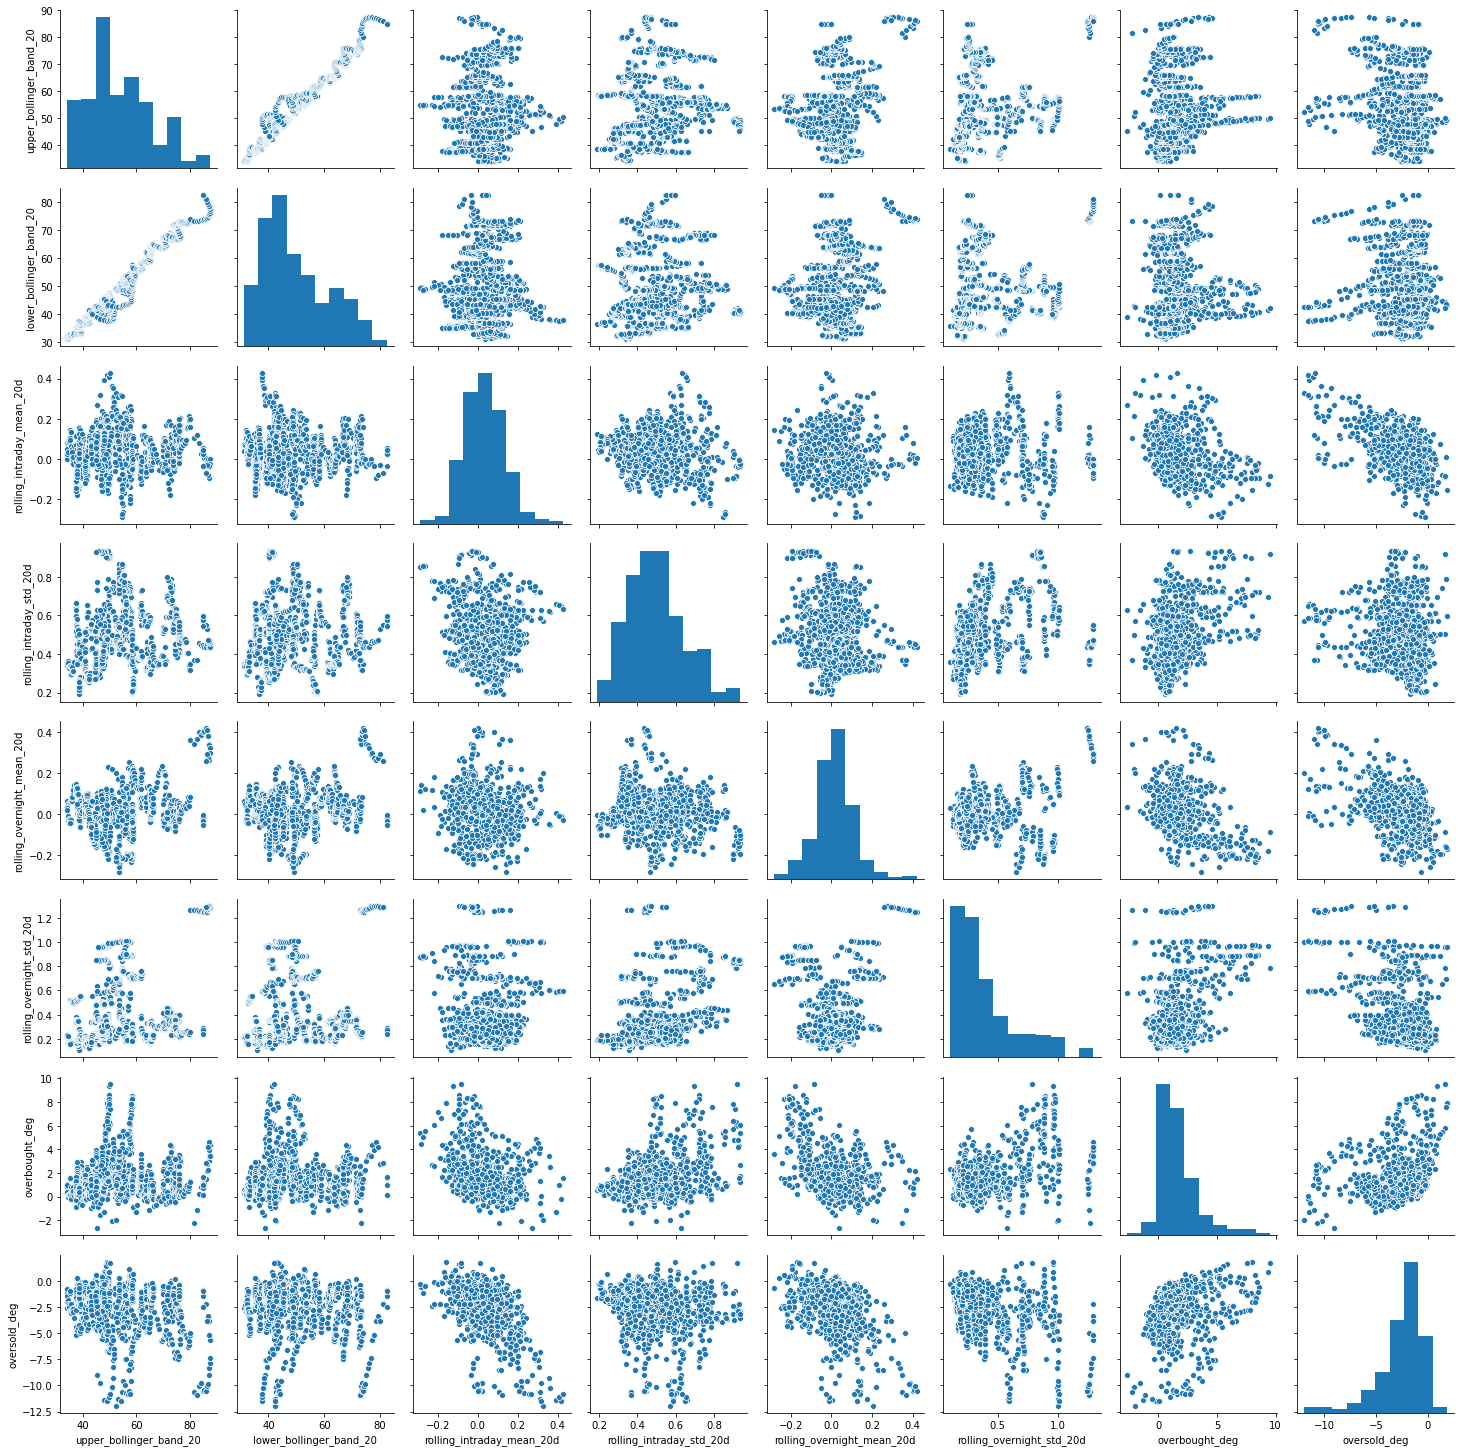

In [22]:
arr = np.array([stats.skew(df[features_rolling])])
skew_rolling = pd.DataFrame(arr, columns=features_rolling)

sns.pairplot(df[features_rolling])

In [24]:
skew_rolling

,upper_bollinger_band_20,lower_bollinger_band_20,rolling_intraday_mean_20d,rolling_intraday_std_20d,rolling_overnight_mean_20d,rolling_overnight_std_20d,overbought_deg,oversold_deg
0,0.628365,0.642971,0.313924,0.555199,0.428422,1.488742,1.682664,-1.631519


Worst offenders are 1. *volume*, 2. *change_overnight*, 3. *wick_top*, 4. *wick_bottom*, 5. *overbought_deg*, 6. *oversold_deg*  
To BoxCox transform, all need to be positive! That's why I did MinMax scaling earlier.

In [25]:
# Correct skew of worst offenders using BoxCox: volume

df_scaled.volume_scaled = df_scaled.volume_scaled + 0.0001  # get '0' error otherwise

volume_boxcoxed,power_val = stats.boxcox(df_scaled.volume_scaled)

df_volume_deskewed = pd.DataFrame(volume_boxcoxed, columns=['volume_deskewed'])  # has 150 rows
df_volume = pd.DataFrame(df['volume'])

df_deskewed1 = pd.concat([df_scaled, df_volume, df_volume_deskewed], axis=1, join='inner')
print(df.shape, df_scaled.shape)

features_skew_compare1 = ['volume', 'volume_scaled', 'volume_deskewed']
arr1 = np.array([stats.skew(df_deskewed1[features_skew_compare1])])
skew_new1 = pd.DataFrame(arr1, columns=features_skew_compare1)
skew_new1  # much better!

(1050, 28) (1050, 15)


,volume,volume_scaled,volume_deskewed
0,3.598804,3.598804,0.16187


In [26]:
# Correct skew of worst offenders using BoxCox: change_overnight_last

df_scaled.change_overnight_last_scaled = df_scaled.change_overnight_last_scaled + 0.0001  # get '0' error otherwise

change_overnight_boxcoxed,power_val = stats.boxcox(df_scaled.change_overnight_last_scaled)

change_overnight_last_deskewed = pd.DataFrame(change_overnight_boxcoxed, columns=['change_overnight_last_deskewed'])

df_change_overnight_last = pd.DataFrame(df['change_overnight_last'])

df_deskewed2 = pd.concat([df_scaled, df_change_overnight_last, change_overnight_last_deskewed], axis=1, join="inner")

features_skew_compare2 =  ['change_overnight_last', 'change_overnight_last_scaled', 'change_overnight_last_deskewed']
arr2 = np.array([stats.skew(df_deskewed2[features_skew_compare2])])
skew_new2 = pd.DataFrame(arr2, columns=features_skew_compare2)
skew_new2   # about the same

,change_overnight_last,change_overnight_last_scaled,change_overnight_last_deskewed
0,1.660014,1.660014,1.680809


In [27]:
# Correct skew of worst offenders using BoxCox: wick_top

df_scaled.wick_top_scaled = df_scaled.wick_top_scaled + 0.0001  # get '0' error otherwise

wick_top_boxcoxed,power_val = stats.boxcox(df_scaled.wick_top_scaled)

wick_top_deskewed = pd.DataFrame(wick_top_boxcoxed, columns=['wick_top_deskewed'])

df_wick_top = pd.DataFrame(df['wick_top'])

df_deskewed3 = pd.concat([df_scaled, df_wick_top, wick_top_deskewed], axis=1, join="inner")

features_skew_compare3 =  ['wick_top', 'wick_top_scaled', 'wick_top_deskewed']
arr3 = np.array([stats.skew(df_deskewed3[features_skew_compare3])])
skew_new3 = pd.DataFrame(arr3, columns=features_skew_compare3)
skew_new3   # improved!

,wick_top,wick_top_scaled,wick_top_deskewed
0,1.596017,1.682664,0.314575


In [28]:
# Correct skew of worst offenders using BoxCox: wick_bottom

df_scaled.wick_bottom_scaled = df_scaled.wick_bottom_scaled + 0.0001  # get '0' error otherwise

wick_bottom_boxcoxed,power_val = stats.boxcox(df_scaled.wick_bottom_scaled)

wick_bottom_deskewed = pd.DataFrame(wick_bottom_boxcoxed, columns=['wick_bottom_deskewed'])

df_wick_bottom = pd.DataFrame(df['wick_bottom'])

df_deskewed4 = pd.concat([df_scaled, df_wick_bottom, wick_bottom_deskewed], axis=1, join="inner")

features_skew_compare4 =  ['wick_bottom', 'wick_bottom_scaled', 'wick_bottom_deskewed']
arr4 = np.array([stats.skew(df_deskewed4[features_skew_compare4])])
skew_new4 = pd.DataFrame(arr4, columns=features_skew_compare4)
skew_new4   # improved!

,wick_bottom,wick_bottom_scaled,wick_bottom_deskewed
0,1.31569,-1.631519,-0.354531


Text(0.5, 0, 'Wick Bottom (Scaled, Deskewed)')

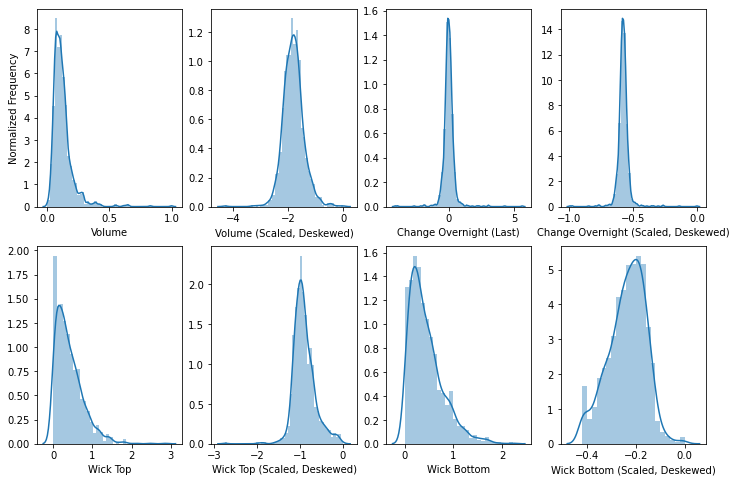

In [29]:
df_deskewed = pd.concat([df_deskewed1, df_deskewed2, df_deskewed3, df_deskewed4], axis=1, join="inner")

figure = sns.mpl.pyplot.figure(figsize=(12,8))

figure.add_subplot(241)
sns.distplot(df_deskewed.volume_scaled)
sns.mpl.pyplot.xlabel("Volume")
sns.mpl.pyplot.ylabel("Normalized Frequency")
figure.add_subplot(242)
sns.distplot(df_deskewed.volume_deskewed)
sns.mpl.pyplot.xlabel("Volume (Scaled, Deskewed)")

figure.add_subplot(243)
sns.distplot(df_deskewed.change_overnight_last)
sns.mpl.pyplot.xlabel("Change Overnight (Last)")
figure.add_subplot(244)
sns.distplot(df_deskewed.change_overnight_last_deskewed)
sns.mpl.pyplot.xlabel("Change Overnight (Scaled, Deskewed)")

figure.add_subplot(245)
sns.distplot(df_deskewed.wick_top)
sns.mpl.pyplot.xlabel("Wick Top")
figure.add_subplot(246)
sns.distplot(df_deskewed.wick_top_deskewed)
sns.mpl.pyplot.xlabel("Wick Top (Scaled, Deskewed)")

figure.add_subplot(247)
sns.distplot(df_deskewed.wick_bottom)
sns.mpl.pyplot.xlabel("Wick Bottom")
figure.add_subplot(248)
sns.distplot(df_deskewed.wick_bottom_deskewed)
sns.mpl.pyplot.xlabel("Wick Bottom (Scaled, Deskewed)")

In [30]:
print(df.shape, df_scaled.shape)

(1050, 28) (1050, 15)


In [31]:
df_scaled = df.join(df_scaled)

df_scaled['day'] = df_scaled['day'] / 31                       # for monthly trends
df_scaled['dayofweek'] = df_scaled['dayofweek'] / 5            # for weekly trends

In [32]:
# Reorganize columns, replacing variables with...

# scaled + deskewed variables
df_scaled["volume"] = df_deskewed["volume_deskewed"]
df_scaled['wick_top'] = df_deskewed["wick_top_deskewed"]                             
df_scaled['wick_bottom'] = df_deskewed["wick_bottom_deskewed"]

# scaled-only variables
                        
df_scaled['overbought_deg'] = df_scaled["overbought_deg_scaled"] 
df_scaled['oversold_deg'] = df_scaled["oversold_deg_scaled"] 
df_scaled['change_overnight'] = df_scaled["change_overnight_scaled"]              # deskewing was not beneficial
df_scaled['change_overnight_last'] = df_scaled["change_overnight_last_scaled"]
df_scaled['change_intraday'] = df_scaled["change_intraday_scaled"]
df_scaled['change_intraday_last'] = df_scaled["change_intraday_last_scaled"]
df_scaled['upper_bollinger_band_20'] = df_scaled["upper_bollinger_band_20_scaled"]
df_scaled['lower_bollinger_band_20'] = df_scaled["lower_bollinger_band_20_scaled"]
df_scaled['rolling_intraday_mean_20d'] = df_scaled["rolling_intraday_mean_20d_scaled"]
df_scaled['rolling_intraday_std_20d'] = df_scaled["rolling_intraday_std_20d_scaled"]
df_scaled['rolling_overnight_mean_20d'] = df_scaled["rolling_overnight_mean_20d_scaled"]
df_scaled['rolling_overnight_std_20d'] = df_scaled["rolling_overnight_std_20d_scaled"]

df_scaled.drop(df_scaled.iloc[:, -15:], inplace=True,axis=1)             # chop off varibles named "_scaled"

df_scaled_master = df_scaled
df_scaled.head(30)

,day,dayofweek,volume,open,high,low,close,wick_top,wick_bottom,change_overnight,...,rolling_overnight_std_20d,overbought_deg,oversold_deg,is_overbought,is_oversold,dayis_Mon,dayis_Tue,dayis_Wed,dayis_Thu,dayis_Fri
0,0.032258,0.4,-1.586770,33.3500,33.6100,33.300,33.580,-1.069928,-0.247722,-0.494774,...,-0.725397,0.090909,0.126126,1,0,0,1,0,0,0
1,0.064516,0.6,-1.373225,33.3600,34.0300,33.290,33.920,-1.120228,-0.254527,-0.113803,...,-0.732336,0.234266,0.283784,1,0,0,0,1,0,0
2,0.096774,0.8,-1.541071,33.8800,34.0000,33.420,33.860,-1.102121,-0.241715,-0.388949,...,-0.707557,0.041958,0.198198,1,0,0,0,0,1,0
3,0.129032,1.0,-1.679347,33.6900,33.9900,33.620,33.880,-1.118147,-0.227565,-0.621764,...,-0.659898,0.104895,0.117117,1,0,0,0,0,0,1
4,0.225806,0.2,-1.626680,33.6000,33.7100,33.200,33.300,-1.024574,-0.185801,-0.007978,...,-0.680857,0.038462,0.045045,1,0,1,0,0,0,0
5,0.258065,0.4,-1.490667,33.3100,33.3300,32.800,33.010,-0.976187,-0.165701,0.097847,...,-0.691907,0.006993,0.094595,1,0,0,1,0,0,0
6,0.290323,0.6,-1.606865,33.0700,33.3499,32.960,33.070,-0.987110,-0.167123,0.478817,...,-0.671307,0.097867,0.049550,1,0,0,0,1,0,0
7,0.322581,0.8,-1.452190,33.3100,33.8900,33.260,33.760,-1.106351,-0.201071,-0.198463,...,-0.667566,0.202797,0.225225,1,0,0,0,0,1,0
8,0.354839,1.0,-1.761743,33.6800,34.1400,33.680,34.130,-1.154273,-0.220608,-0.515939,...,-0.695475,0.160839,0.202703,1,0,0,0,0,0,1
9,0.451613,0.2,-1.830889,33.9000,34.5000,33.780,34.450,-1.182236,-0.236671,0.436487,...,-0.876288,0.209790,0.301802,0,0,1,0,0,0,0


In [33]:
# remove non-predictive features

features_all = df_scaled.columns.tolist()

features_to_ignore = ['open', 'close', 'high', 'low']     # unscaled, not useful in current form... general trend is upward    

for name in features_to_ignore:
    features_all.remove(name)

print(features_all)

['day', 'dayofweek', 'volume', 'wick_top', 'wick_bottom', 'change_overnight', 'change_overnight_last', 'change_intraday', 'change_intraday_last', 'upper_bollinger_band_20', 'lower_bollinger_band_20', 'rolling_intraday_mean_20d', 'rolling_intraday_std_20d', 'rolling_overnight_mean_20d', 'rolling_overnight_std_20d', 'overbought_deg', 'oversold_deg', 'is_overbought', 'is_oversold', 'dayis_Mon', 'dayis_Tue', 'dayis_Wed', 'dayis_Thu', 'dayis_Fri']


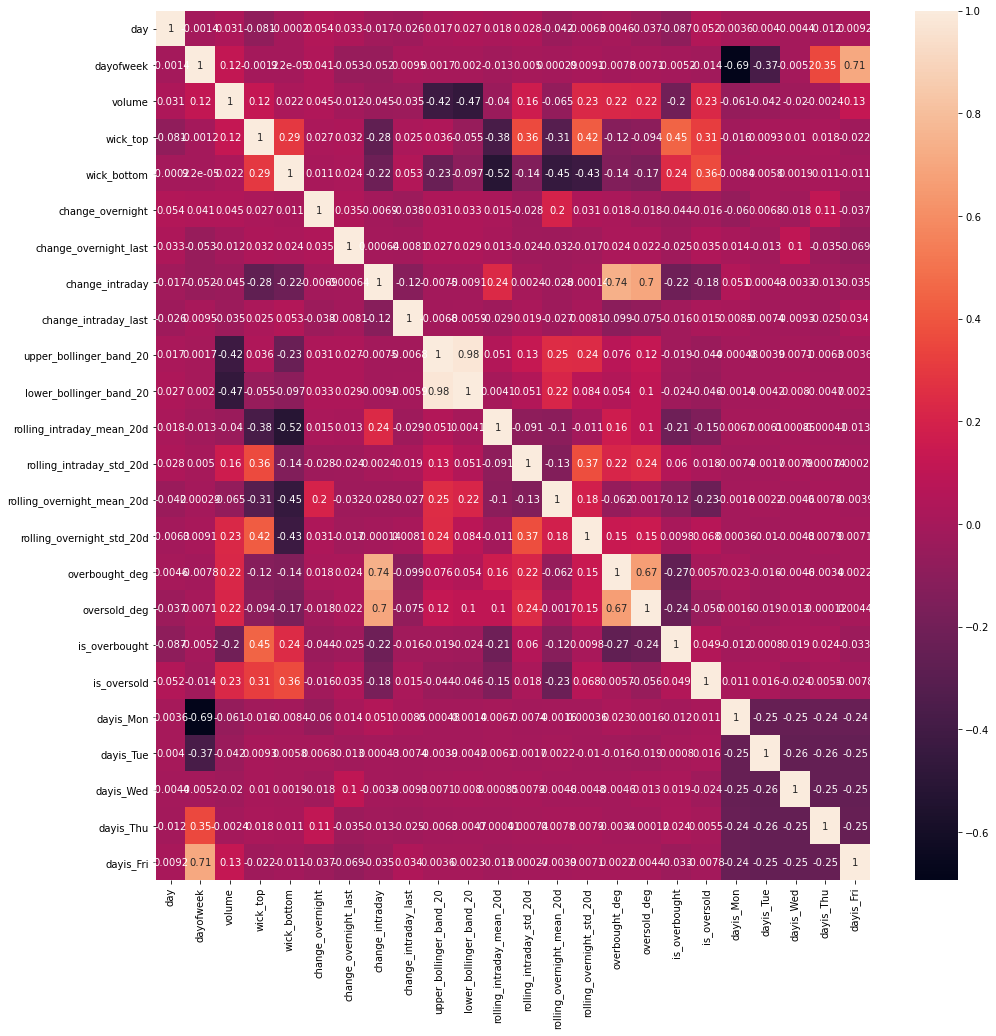

In [34]:
plt.figure(figsize = (16,16))

sns.heatmap(df_scaled[features_all].corr(), annot=True)

In [35]:
#3.3 Define polynomial features (interactions only)

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)

# remove some features (e.g. change_overnight)
features_all_test = features_all.copy()
features_all_test.remove('change_overnight')   # obviously predictive (but unknown at time of prediction)
features_all_test.remove('change_intraday')    # obviously predictive (but unknown at time of prediction - of situation #2)

X = df_scaled[features_all_test]
X_poly = poly.fit_transform(X)

features_all_poly = poly.get_feature_names(features_all_test)
df_poly = pd.DataFrame(X_poly, columns=features_all_poly)

df_poly = df_poly.drop(["1"], axis=1)                                     # drop constant term
df_poly = df_poly.iloc[:, :-15]                                           # get rid of useless dummy interactions
features_all_poly = features_all_poly[1:-15]

df_poly

,day,dayofweek,volume,wick_top,wick_bottom,change_overnight_last,change_intraday_last,upper_bollinger_band_20,lower_bollinger_band_20,rolling_intraday_mean_20d,...,oversold_deg dayis_Tue,oversold_deg dayis_Wed,oversold_deg dayis_Thu,oversold_deg dayis_Fri,is_overbought is_oversold,is_overbought dayis_Mon,is_overbought dayis_Tue,is_overbought dayis_Wed,is_overbought dayis_Thu,is_overbought dayis_Fri
0,0.032258,0.4,-1.586770,-1.069928,-0.247722,0.415819,0.628378,-1.669991,-1.619677,0.028295,...,0.126126,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
1,0.064516,0.6,-1.373225,-1.120228,-0.254527,0.402375,0.497748,-1.662417,-1.603927,0.408147,...,0.000000,0.283784,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
2,0.096774,0.8,-1.541071,-1.102121,-0.241715,0.391000,0.545045,-1.660037,-1.583689,0.330164,...,0.000000,0.000000,0.198198,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
3,0.129032,1.0,-1.679347,-1.118147,-0.227565,0.420989,0.434685,-1.664928,-1.555070,0.505248,...,0.000000,0.000000,0.000000,0.117117,0.0,0.0,0.0,0.0,0.0,1.0
4,0.225806,0.2,-1.626680,-1.024574,-0.185801,0.426160,0.434685,-1.673629,-1.531886,0.135861,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.709677,0.6,-2.101472,-0.700279,-0.235483,0.425126,0.558559,2.675618,2.685359,-1.037353,...,0.000000,0.031532,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
1046,0.774194,1.0,-4.298647,-0.879695,-0.168371,0.440638,0.628378,2.587629,2.814911,-0.690204,...,0.000000,0.000000,0.000000,0.216216,0.0,0.0,0.0,0.0,0.0,1.0
1047,0.870968,0.2,-2.212850,-0.982992,-0.200155,0.402375,0.684685,2.588056,2.814990,-0.126715,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1048,0.903226,0.4,-2.041962,-1.147689,-0.250431,0.437535,0.193694,2.601992,2.809189,0.185217,...,0.387387,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#features_all_poly

## Testing Different Outcome Variables

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

### 4.1 Overnight Change
We want to know if we make a profit by buying at close and selling at open the next day.  
1 (True) if change_overnight is positive, 0 (False) if negative

In [37]:
#1 Define outcome variable ('y')

features_all_test = features_all.copy()
features_all_test.remove('change_overnight')   # obviously predictive (but unknown at time of prediction) 

X = df_scaled[features_all_test]
df_scaled["success_change_overnight"] = np.where(df["change_overnight"]>0, 1, 0)
y1 = df_scaled["success_change_overnight"]

In [38]:
#2 Split into train:test sets

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=1234)

#3.1 Train regression models

logreg1 = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1234)
logreg1.fit(X_train, y1_train)

tree1 = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree1.fit(X_train, y1_train)

rf1 = RandomForestClassifier(n_estimators = 100, random_state=1234)
rf1.fit(X_train, y1_train)

#3.2 Compare with dumb classifier

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y1_train)
y1_dumb_class = dumb_model.predict(X_test)
accuracy_dumb1 = accuracy_score(y1_test, y1_dumb_class)

#4 Validate model

y1_pred_log = logreg1.predict(X_test)
accuracy_log1 = accuracy_score(y1_test, y1_pred_log)
y1_pred_tree = tree1.predict(X_test)
accuracy_tree1 = accuracy_score(y1_test, y1_pred_tree)
y1_pred_rf = rf1.predict(X_test)
accuracy_rf1 = accuracy_score(y1_test, y1_pred_rf)

print("Accuracy score (logreg, all features): ", accuracy_log1)
print("Accuracy score (decision tree): ", accuracy_tree1)
print("Accuracy score (random forest): ", accuracy_rf1)
print("Accuracy score (dummy, most frequent): ", accuracy_dumb1)

Accuracy score (logreg, all features):  0.5873015873015873
Accuracy score (decision tree):  0.4984126984126984
Accuracy score (random forest):  0.5206349206349207
Accuracy score (dummy, most frequent):  0.4984126984126984


In [39]:
# how important are features (in decision tree model)

feature_names = X_train.columns.tolist()
feature_values = rf1.feature_importances_

featrank1 = pd.DataFrame(feature_values, index=feature_names, columns=['importance']).sort_values(by=['importance'], ascending=False)
featrank1.head(10)

,importance
rolling_overnight_std_20d,0.076150
wick_top,0.072322
wick_bottom,0.072246
rolling_overnight_mean_20d,0.071458
rolling_intraday_mean_20d,0.064496
change_intraday,0.062026
rolling_intraday_std_20d,0.060734
change_overnight_last,0.060408
change_intraday_last,0.059403
volume,0.058863


### What about polynomial features?

In [40]:
#1 Define outcome variable ('y')

features_all_poly = features_all_poly.copy()   # already removed 'change_overnight' and 'change_intraday'

X = df_poly[features_all_poly]
df_poly["success_change_overnight"] = np.where(df["change_overnight"]>0, 1, 0)
y1 = df_poly["success_change_overnight"]

#2 Split into train:test sets

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=1234)

# print("Training data size:", X_train.shape)
# print("Testing data size:", X_test.shape)

#3.1 Train regression models

logreg1 = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1234)
logreg1.fit(X_train, y1_train)

tree1 = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree1.fit(X_train, y1_train)

rf1 = RandomForestClassifier(n_estimators = 100, random_state=1234)
rf1.fit(X_train, y1_train)

#3.2 Compare with dumb classifier

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y1_train)
y1_dumb_class = dumb_model.predict(X_test)
accuracy_dumb1 = accuracy_score(y1_test, y1_dumb_class)

#4 Validate model

y1_pred_log = logreg1.predict(X_test)
accuracy_log1 = accuracy_score(y1_test, y1_pred_log)
y1_pred_tree = tree1.predict(X_test)
accuracy_tree1 = accuracy_score(y1_test, y1_pred_tree)
y1_pred_rf = rf1.predict(X_test)
accuracy_rf1 = accuracy_score(y1_test, y1_pred_rf)

print("Accuracy score (logreg, all features): ", accuracy_log1)
print("Accuracy score (decision tree): ", accuracy_tree1)
print("Accuracy score (random forest): ", accuracy_rf1)
print("Accuracy score (dummy, most frequent): ", accuracy_dumb1)

Accuracy score (logreg, all features):  0.6063492063492063
Accuracy score (decision tree):  0.526984126984127
Accuracy score (random forest):  0.5333333333333333
Accuracy score (dummy, most frequent):  0.4984126984126984


In [42]:
# how important are features (in decision tree model)

feature_names = X_train.columns.tolist()
feature_values = rf1.feature_importances_

featrank1poly = pd.DataFrame(feature_values, index=feature_names, columns=['importance']).sort_values(by=['importance'], ascending=False)
featrank1poly.head(20)

,importance
dayofweek wick_bottom,0.009548
wick_top is_overbought,0.009448
wick_bottom change_intraday_last,0.008630
rolling_overnight_mean_20d rolling_overnight_std_20d,0.008614
volume wick_bottom,0.008546
wick_top rolling_overnight_mean_20d,0.008156
wick_top lower_bollinger_band_20,0.008090
volume is_overbought,0.008075
change_overnight_last rolling_overnight_std_20d,0.008035
day change_overnight_last,0.008031


### 5.2 Intraday Change
We want to know if we make a profit by buying at open and selling at close the same day.  
1 (True) if change_intraday is positive, 0 (False) if negative

In [43]:
features_all_test = features_all.copy()
features_all_test.remove('change_intraday')    # obviously predictive (but unknown at time of prediction) 
features_all_test.remove('change_overnight')   # obviously predictive (but unknown at time of prediction) 

X = df_scaled[features_all_test]
df_scaled["success_change_intraday"] = np.where(df["close"]-df["open"]>0, 1, 0)
y2 = df_scaled["success_change_intraday"]

In [44]:
# Split into train:test sets

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=1234)

# Train regression models

logreg2 = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1234)
logreg2.fit(X_train, y2_train)

tree2 = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree2.fit(X_train, y2_train)

rf2 = RandomForestClassifier(n_estimators = 100, random_state=1234)
rf2.fit(X_train, y2_train)

# Compare with dumb classifier

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y2_train)
y2_dumb_class = dumb_model.predict(X_test)
accuracy_dumb2 = accuracy_score(y2_test, y2_dumb_class)

# Validate model

y2_pred_log = logreg2.predict(X_test)
accuracy_log2 = accuracy_score(y2_test, y2_pred_log)
y2_pred_tree = tree2.predict(X_test)
accuracy_tree2 = accuracy_score(y2_test, y2_pred_tree)
y2_pred_rf = rf2.predict(X_test)
accuracy_rf2 = accuracy_score(y2_test, y2_pred_rf)

print("Accuracy score (logreg, all features): ", accuracy_log2)
print("Accuracy score (decision tree): ", accuracy_tree2)
print("Accuracy score (random forest): ", accuracy_rf2)
print("Accuracy score (dummy, most frequent): ", accuracy_dumb2)

Accuracy score (logreg, all features):  0.8285714285714286
Accuracy score (decision tree):  0.8412698412698413
Accuracy score (random forest):  0.8317460317460318
Accuracy score (dummy, most frequent):  0.5142857142857142


In [45]:
feature_names = X_train.columns.tolist()
feature_values = rf2.feature_importances_

featrank2 = pd.DataFrame(feature_values, index=feature_names, columns=['importance']).sort_values(by=['importance'], ascending=False)
featrank2.head(10)

,importance
oversold_deg,0.286520
overbought_deg,0.252931
wick_top,0.053528
wick_bottom,0.041485
rolling_intraday_mean_20d,0.039823
rolling_intraday_std_20d,0.038778
volume,0.035213
lower_bollinger_band_20,0.034346
upper_bollinger_band_20,0.034072
rolling_overnight_std_20d,0.031140


### What about polynomial features?

In [46]:
features_all_poly = features_all_poly.copy()   # already removed 'change_overnight' and 'change_intraday'

X = df_poly[features_all_poly]
df_poly["success_change_intraday"] = np.where(df["close"]-df["open"]>0, 1, 0)
y2 = df_poly["success_change_intraday"]

# Split into train:test sets

X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=1234)

# Train regression models

logreg2 = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1234)
logreg2.fit(X_train, y2_train)

tree2 = DecisionTreeClassifier(max_depth=3, random_state=1234)
tree2.fit(X_train, y2_train)

rf2 = RandomForestClassifier(n_estimators = 100, random_state=1234)
rf2.fit(X_train, y2_train)

# Compare with dumb classifier

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y2_train)
y2_dumb_class = dumb_model.predict(X_test)
accuracy_dumb2 = accuracy_score(y2_test, y2_dumb_class)

# Validate model

y2_pred_log = logreg2.predict(X_test)
accuracy_log2 = accuracy_score(y2_test, y2_pred_log)
y2_pred_tree = tree2.predict(X_test)
accuracy_tree2 = accuracy_score(y2_test, y2_pred_tree)
y2_pred_rf = rf2.predict(X_test)
accuracy_rf2 = accuracy_score(y2_test, y2_pred_rf)

print("Accuracy score (logreg, all features): ", accuracy_log2)
print("Accuracy score (decision tree): ", accuracy_tree2)
print("Accuracy score (random forest): ", accuracy_rf2)
print("Accuracy score (dummy, most frequent): ", accuracy_dumb2)

Accuracy score (logreg, all features):  0.834920634920635
Accuracy score (decision tree):  0.8444444444444444
Accuracy score (random forest):  0.8380952380952381
Accuracy score (dummy, most frequent):  0.5142857142857142


In [47]:
feature_names = X_train.columns.tolist()
feature_values = rf2.feature_importances_

featrank2 = pd.DataFrame(feature_values, index=feature_names, columns=['importance']).sort_values(by=['importance'], ascending=False)
featrank2.head(10)

,importance
volume overbought_deg,0.049977
overbought_deg oversold_deg,0.047977
wick_top oversold_deg,0.044981
change_overnight_last oversold_deg,0.043232
wick_top overbought_deg,0.043200
wick_bottom oversold_deg,0.042982
oversold_deg,0.040979
volume oversold_deg,0.033489
wick_bottom overbought_deg,0.031589
change_intraday_last overbought_deg,0.030796


### 3.3 Test Model Performance

How well do we perform by trading when the model is confident, versus at random?

In [49]:
# major parameters

investment = 1000          # dollars
confidence = 0.9           # cut-off value

In [50]:
# buy at close, sell at open (next day)
# informed by logreg1

investment_model = pd.Series(0)
investment_model[0] = investment

df['proba_buy'] = logreg1.predict_proba(X)[:,1]

for i in range(0, len(df)):
    if df['proba_buy'][i] > confidence:
        investment = (investment/df['close'][i])*df['open'][i+1]
        investment_model[i+1] = investment
    else:
        investment_model[i+1] = investment

df['investment_model'] = pd.Series(investment_model, name='investment_model')

In [51]:
# bought the same number of times, but on random days

import random

proba_buy_true = np.where(df["proba_buy"]>confidence, 1, 0)
num_buys = proba_buy_true.sum()

buy_days = random.sample(range(0,len(df)), num_buys)               # random each time

In [52]:
investment = 1000          # dollars
investment_random = pd.Series(0)
investment_random[0] = investment

for i in range(0, len(df)):
    if i in buy_days:
        investment = (investment/df['close'][i])*df['open'][i+1]
        investment_random[i+1] = investment
    else:
        investment_random[i+1] = investment

df['investment_random'] = pd.Series(investment_random, name='investment_random')

In [54]:
#df.iloc[:, -3:].head(50)
df.iloc[:, -3:].tail(50)

,proba_buy,investment_model,investment_random
1000,0.535596,1501.771487,957.617890
1001,0.739575,1501.771487,957.617890
1002,0.393055,1501.771487,957.617890
1003,0.759584,1501.771487,957.617890
1004,0.705934,1501.771487,957.617890
1005,0.476654,1501.771487,957.617890
1006,0.634287,1501.771487,957.617890
1007,0.343480,1501.771487,957.617890
1008,0.659344,1501.771487,957.617890
1009,0.539479,1501.771487,957.617890


In [55]:
buyandhold = (investment/df['close'][0])*df['open'][len(df)-1]
buyandhold

2397.3238750383102

## 4.1 Cross Validation

In [ ]:
# next steps...

from sklearn.model_selection import KFold, cross_val_score

### 5 Limitations & Next Steps

- **Did not really investigate seasonality (periodicity):**  
For example, maybe large price jumps are common in January, or big drops are common in May.  
From 'day' and 'dayofweek', there do not appear to be clear monthly/weekly cycles 

- **Few common technical indicators: e.g. 'overbought' and 'oversold'**  
        
- **Unrealistic trading strategies**  
Unusual to only enter and exit trades at open/close; very unusual to hold for <24 h.  
In the future, should test buy-and-hold strategies for certain windows:  
-- estimate change in price over next X days using linear regression  
-- define 'success' as sign (+, -) of change



### Thank you for this informative and challenging course!